## ABC applied to position reconstruction

*Bart Pelssers, 26-02-2018*

This notebook provides some ingredients for applying the ABC algorithm to position reconstruction, the most basic case. Just to test the framework.


* Provides:
  * prior mean
  * forward model
  * summary statistic
  
*Umberto Simola, 22-03-2018*

Provided the ABC-PMC algorithm for running the analyses.

In [1]:
import numpy as np

In [2]:
from abc_reconstruction.simpleModel import SimpleModel as Model
from abc_reconstruction.utils import PriorPosition, Generator

You don't have ROOT or root_pandas, root truth file output is disabled


In [3]:
# Setup the Models
model = Model()
prior_mean = PriorPosition()
generator = Generator(model)

# Python 3.5 and ELFI

In [4]:
import sys
sys.version

'3.5.5 |Anaconda, Inc.| (default, Mar 12 2018, 23:12:44) \n[GCC 7.2.0]'

In [5]:
import elfi

In [6]:
###Observed dataset
trueCoordMatrix=np.loadtxt('data/truepos')
print("True Coordinates")
print(trueCoordMatrix[0])
trueCoord=trueCoordMatrix[0]
TrueModel=model(trueCoord[0], trueCoord[1])

y_obs=TrueModel
#print(y_obs)

True Coordinates
[  2.62643434 -17.96082368]


In [7]:
prior_mean = PriorPosition()
naiveCoord=prior_mean(y_obs)

print(naiveCoord)

(4.115222817130077, -15.358220637996187)


In [8]:
model=elfi.tools.vectorize(model)

In [9]:
###Prior distributions: The constrain is not present, move to CustomPrior_xy defined below

#xProp=elfi.Prior('norm',trueCoord[0],15)
#yProp=elfi.Prior('norm',trueCoord[1],15)
xProp=elfi.Prior('norm',naiveCoord[0],15)
yProp=elfi.Prior('norm',naiveCoord[1],15)

#print(elfi.Simulator.generate(xProp), elfi.Simulator.generate(yProp))

In [10]:
###Simulated Dataset
Y = elfi.Simulator(model, xProp, yProp, observed=y_obs)
#Y = elfi.Simulator(model, xProp, yProp)
print(elfi.Simulator.generate(Y))

[[ 0.39617596  0.43168447  0.26702425  0.25823422  0.15633213  0.17753983
   0.20715811  0.11964587  0.12811864  0.20862785  0.28270893  0.13849899
   0.13031873  0.16186534  0.18685664  0.20690147  0.11097093  0.18103565
   0.24042451  0.23692779  0.27953869  0.41978065  0.32009036  0.55891767
   0.88735635  1.27221676  1.89201811  3.42751125  4.75488448  5.46785032
   4.53794952  2.9493797   1.96669271  1.05544284  0.8296463   0.48300528
   0.80672236  0.74137917  0.54407929  0.46029683  0.49884115  0.55798276
   0.47307647  0.39285963  0.40316576  0.33332561  0.38334675  0.39858344
   0.39224328  0.4607459   0.57295228  0.61854459  0.61916003  0.67778202
   0.86551637  0.99117162  1.30782453  2.07665779  4.88515102 11.79333786
  21.23134749 13.68039525  5.29609945  2.34917806  1.19219247  1.18211473
   1.01499812  0.80154168  0.52844806  0.60260074  0.60922208  0.63346764
   0.47101421  0.4810446   0.58000212  0.60044372  0.50349116  0.49862939
   0.64292763  0.81928596  0.82056768 

In [11]:
d = elfi.Distance('euclidean', Y)

print(elfi.Simulator.generate(d))

[203.37497783]


In [12]:
import scipy.spatial.distance

def rho(y_obs, Y):
    return scipy.spatial.distance.cdist(np.array([y_obs]),np.array([elfi.Simulator.generate(Y)]),'euclidean')
rho(y_obs,Y)

ValueError: XB must be a 2-dimensional array.

In [13]:
log_d = elfi.Operation(np.log, d)

print(elfi.Simulator.generate(log_d))

[5.178864]


In [17]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=20, update_interval=5, 
                   bounds={'xProp':(-30, 30), 'yProp':(-30, 30)}, acq_noise_var=[0.1, 0.1])

In [18]:
%time post = bolfi.fit(n_evidence=100)

CoordinateOutOfRangeException: In executing node 'Y': Expected light pattern at coordinates (12.932807197879214, -48.065959952021174) consists of only zeros!.

In [17]:
bolfi.target_model


Name : GP regression
Objective : 175.4673407658091
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |      priors    
  sum.rbf.variance         |  0.5339359512779536  |      +ve      |  Ga(0.0013, 1) 
  sum.rbf.lengthscale      |   17.14323226316107  |      +ve      |    Ga(20, 1)   
  sum.bias.variance        |  0.6291648890035265  |      +ve      |  Ga(0.00033, 1)
  Gaussian_noise.variance  |  1.0600933433342847  |      +ve      |                

<Figure size 432x288 with 0 Axes>

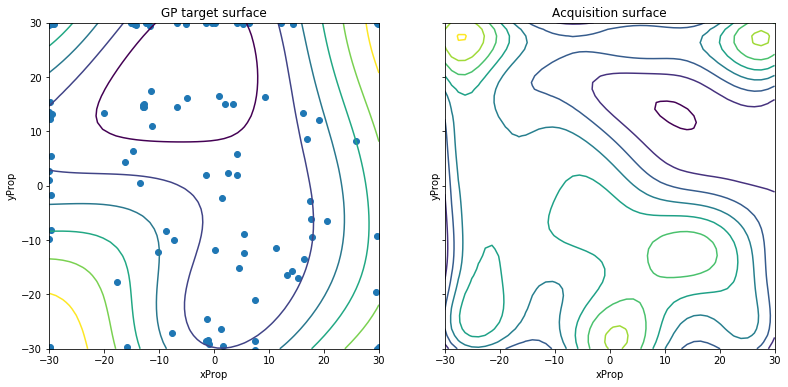

In [18]:
bolfi.plot_state();

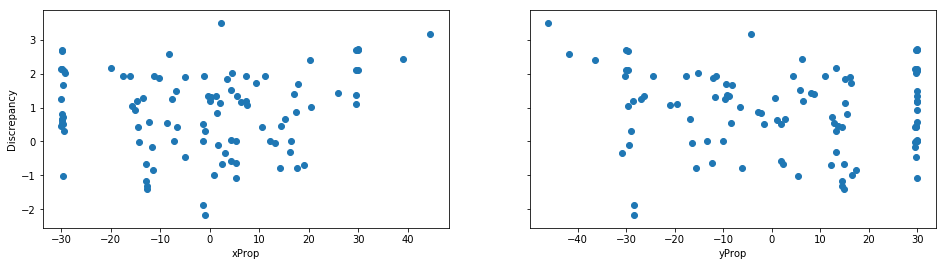

In [19]:
bolfi.plot_discrepancy();

In [228]:
post2 = bolfi.extract_posterior(-1.)

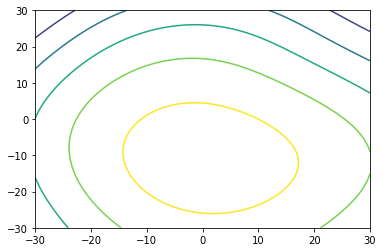

In [229]:
post.plot(logpdf=True)

In [230]:
%time result_BOLFI = bolfi.sample(100, info_freq=100)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
xProp 1819.3945528544295 1.0019418939784488
yProp 1874.6850229564006 1.0003173178737246
CPU times: user 4min 42s, sys: 1.51 s, total: 4min 43s
Wall time: 2min 21s


In [231]:
result_BOLFI

Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -0.479
Sample means: xProp: 1.49, yProp: -8.63

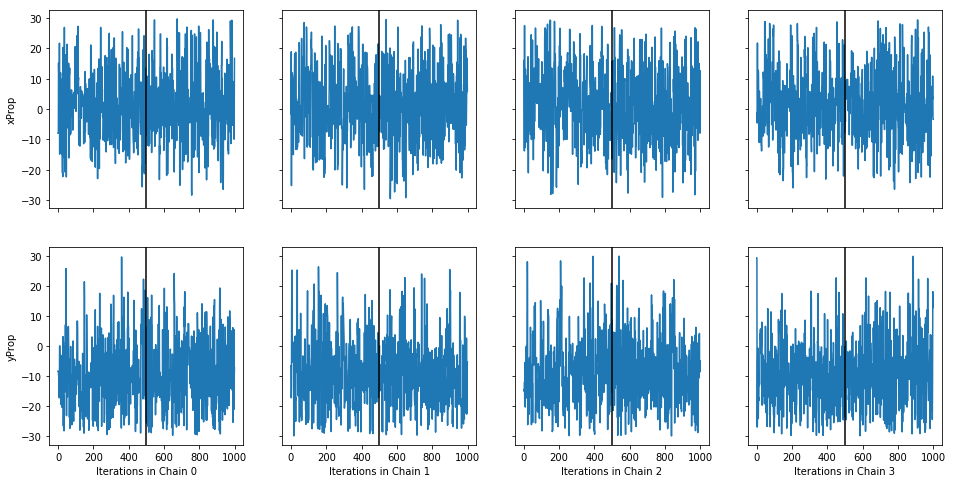

In [232]:
result_BOLFI.plot_traces();

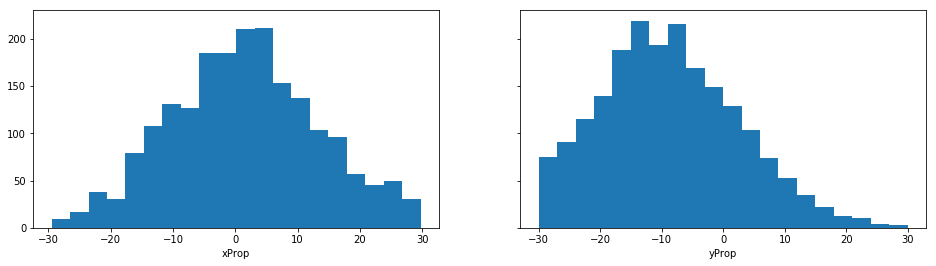

In [233]:
result_BOLFI.plot_marginals();

In [234]:
result_BOLFI.sample_means_array

array([ 1.48788546, -8.62636773])